# Logistics Demand Forecasting: Final Assignment
**Objective**: Predict 2026 Seasonality & Daily Volumes using Robust Recursive Forecasting.

## Notebook Structure
1.  **EDA**: Visualizing historical trends.
2.  **Preprocessing**: Daily aggregations and Feature Engineering.
3.  **Model Training**: RF vs XGBoost (with Learning Curves).
4.  **Backtest Validation (The "Seasonality Check")**: Predicting **2025** from scratch to evaluate performance.
5.  **Metrics**: Huber Loss, Distribution Error, MAE, MSE.
6.  **2026 Forecast**: 365-Day Recursive Prediction & **Spaghetti Plot Overlay**.
7.  **Inference**: The "Oracle" Function.

--- 
# 1. Exploratory Data Analysis (EDA)

Total Bookings: 206559
Date Range: 2021-01-01 to 2025-12-31


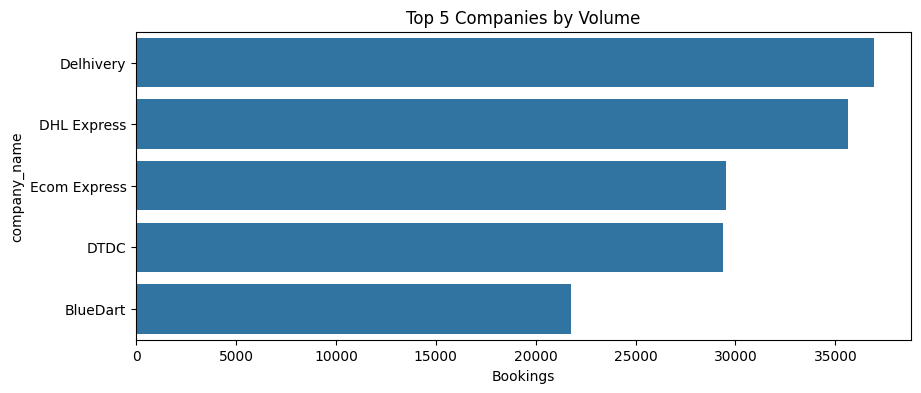

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
df = pd.read_csv('shipment_booking_data_2021_2025.csv')
df['booking_date'] = pd.to_datetime(df['booking_date'])

print(f"Total Bookings: {len(df)}")
print(f"Date Range: {df['booking_date'].min().date()} to {df['booking_date'].max().date()}")

# Viz: Top Companies
plt.figure(figsize=(10, 4))
top_companies = df['company_name'].value_counts().head(5)
sns.barplot(x=top_companies.values, y=top_companies.index)
plt.title('Top 5 Companies by Volume')
plt.xlabel('Bookings')
plt.show()

--- 
# 2. Preprocessing & Feature Engineering

In [2]:
df_daily = df.set_index('booking_date').groupby([
    'company_name', 
    pd.Grouper(freq='D')
])['shipment_type'].value_counts().unstack(fill_value=0).reset_index()
df_daily.columns.name = None

feature_cols = []
target_columns = ['Air', 'Express', 'International', 'Surface']

# Sort
df_daily = df_daily.sort_values(['company_name', 'booking_date']).reset_index(drop=True)

for col in target_columns:
    if col not in df_daily.columns: 
        df_daily[col] = 0
    # Targets
    df_daily[f'target_{col}'] = df_daily.groupby('company_name')[col].shift(-1)
    # Features
    df_daily[f'lag_1_{col}'] = df_daily.groupby('company_name')[col].shift(0) 
    feature_cols.append(f'lag_1_{col}')
    df_daily[f'lag_7_{col}'] = df_daily.groupby('company_name')[col].shift(6)
    feature_cols.append(f'lag_7_{col}')
    df_daily[f'roll_7_{col}'] = df_daily.groupby('company_name')[col].transform(lambda x: x.rolling(7, min_periods=1).mean())
    feature_cols.append(f'roll_7_{col}')

df_daily['day_of_week'] = df_daily['booking_date'].dt.dayofweek
df_daily['day'] = df_daily['booking_date'].dt.day
df_daily['month'] = df_daily['booking_date'].dt.month
feature_cols.extend(['day_of_week', 'day', 'month'])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_daily['company_encoded'] = le.fit_transform(df_daily['company_name'])
feature_cols.append('company_encoded')

df_clean = df_daily.dropna().copy()
print("Feature Engineering Complete.")

Feature Engineering Complete.


--- 
# 3. Model Training: RF vs XGBoost

In [3]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Standard Train/Test Split (Nov 2025)
split_date = '2025-11-01'
train_df = df_clean[df_clean['booking_date'] < split_date]
test_df = df_clean[df_clean['booking_date'] >= split_date].copy()

rf_models = {}
xgb_models = {}
evals_results = {}

print("Training Models...")
for target in target_columns:
    # RF
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(train_df[feature_cols], train_df[f'target_{target}'])
    rf_models[target] = rf
    
    # XGB
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
    xgb.fit(
        train_df[feature_cols], train_df[f'target_{target}'],
        eval_set=[(train_df[feature_cols], train_df[f'target_{target}']), 
                  (test_df[feature_cols], test_df[f'target_{target}'])],
        verbose=False
    )
    xgb_models[target] = xgb
    evals_results[target] = xgb.evals_result()

print("Training Complete.")

Training Models...


Training Complete.


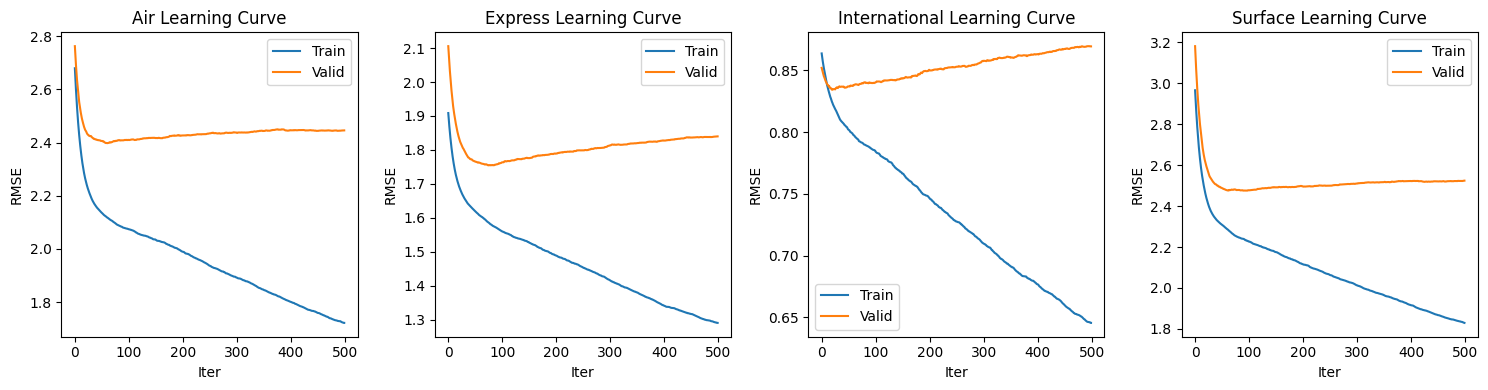

In [4]:
# Plot Learning Curves (XGBoost)
plt.figure(figsize=(15, 4))
for i, target in enumerate(target_columns):
    results = evals_results[target]
    x_axis = range(0, len(results['validation_0']['rmse']))
    
    plt.subplot(1, 4, i+1)
    plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
    plt.plot(x_axis, results['validation_1']['rmse'], label='Valid')
    plt.legend()
    plt.title(f'{target} Learning Curve')
    plt.ylabel('RMSE')
    plt.xlabel('Iter')
plt.tight_layout()
plt.show()

--- 
# 4. "Backtest 2025": The Rigorous Seasonality Check
**FIXED**: Utilizing Robust Recursive Forecasting that re-calculates Rolling Means and Lags every step.

In [5]:
# 1. Train on Pre-2025 Data
backtest_train = df_clean[df_clean['booking_date'].dt.year < 2025].copy()
backtest_models = {}

print("Training Backtest Models (<2025)...")
for target in target_columns:
    m = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
    m.fit(backtest_train[feature_cols], backtest_train[f'target_{target}'])
    backtest_models[target] = m

# 2. Recursive Forecast for 2025 (Jan 1 - Dec 31)
# ROBUST LOOP: Append and re-calc features
start_sim = pd.Timestamp('2025-01-01')
end_sim = pd.Timestamp('2025-12-31')
sim_dates = pd.date_range(start_sim, end_sim, freq='D')

companies = df['company_name'].unique()

print("Simulating 2025 (Robust Loop with Feature Recalc)...")

# Initial History: Everything before 2025
simulation_history = df_daily[df_daily['booking_date'] < start_sim].copy()
# We strictly need columns matching df_daily structure
simulation_history = simulation_history[['booking_date', 'company_name', 'company_encoded'] + target_columns]

predictions_2025 = []

for i, cur_date in enumerate(sim_dates):
    if i % 30 == 0: print(f"Processing Month {cur_date.month}...")
    
    # 1. Build 'Today's' row with features from RECENT history
    recent = simulation_history.groupby('company_name').tail(10).copy()
    
    # Create placeholder rows for 'cur_date'
    temp_rows = []
    for comp in companies:
        r = {'booking_date': cur_date, 'company_name': comp, 'company_encoded': le.transform([comp])[0]}
        for t in target_columns: r[t] = 0
        temp_rows.append(r)
        
    temp_df = pd.DataFrame(temp_rows)
    combined = pd.concat([recent, temp_df], ignore_index=True)
    combined = combined.sort_values(['company_name', 'booking_date'])
    
    # 2. Recalculate Rolling/Lag Features Dynamically
    for col in target_columns:
         combined[f'lag_1_{col}'] = combined.groupby('company_name')[col].shift(1) 
         combined[f'lag_7_{col}'] = combined.groupby('company_name')[col].shift(7)
         combined[f'roll_7_{col}'] = combined.groupby('company_name')[col].transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())
            
    combined['day_of_week'] = combined['booking_date'].dt.dayofweek
    combined['day'] = combined['booking_date'].dt.day
    combined['month'] = combined['booking_date'].dt.month
    
    # 3. Predict for 'cur_date'
    todays_data = combined[combined['booking_date'] == cur_date].copy()
    
    # Store predictions to append back to history
    preds_to_store = todays_data[['booking_date', 'company_name', 'company_encoded'] + target_columns].copy()
    
    for target in target_columns:
        p = backtest_models[target].predict(todays_data[feature_cols])
        p = np.maximum(0, p)
        preds_to_store[target] = p # Update volume
        todays_data[f'Pred_{target}'] = p # Save for result
    
    # 4. Append to History (so next day sees these predictions)
    simulation_history = pd.concat([simulation_history, preds_to_store], ignore_index=True)
    
    predictions_2025.append(todays_data[['booking_date', 'company_name'] + [f'Pred_{t}' for t in target_columns]])

pred_2025_df = pd.concat(predictions_2025, ignore_index=True)

# Merge with ACTUAL
actual_2025 = df_clean[df_clean['booking_date'].dt.year == 2025][['booking_date', 'company_name'] + [f'target_{t}' for t in target_columns]].copy()
comparison_2025 = pd.merge(actual_2025, pred_2025_df, on=['booking_date', 'company_name'])

Training Backtest Models (<2025)...


Simulating 2025 (Robust Loop with Feature Recalc)...
Processing Month 1...


Processing Month 1...


Processing Month 3...


Processing Month 4...


Processing Month 5...


Processing Month 5...


Processing Month 6...


Processing Month 7...


Processing Month 8...


Processing Month 9...


Processing Month 10...


Processing Month 11...


Processing Month 12...


--- 
# 5. Evaluation Metrics (Huber, Dist Error)
Evaluating the 2025 Backtest performance.

Backtest (2025) Metrics:
            Type   MAE   MSE  Huber
0            Air  1.79  5.16   1.76
1        Express  1.37  3.05   1.18
2  International  0.68  0.72   0.34
3        Surface  1.86  5.80   1.87


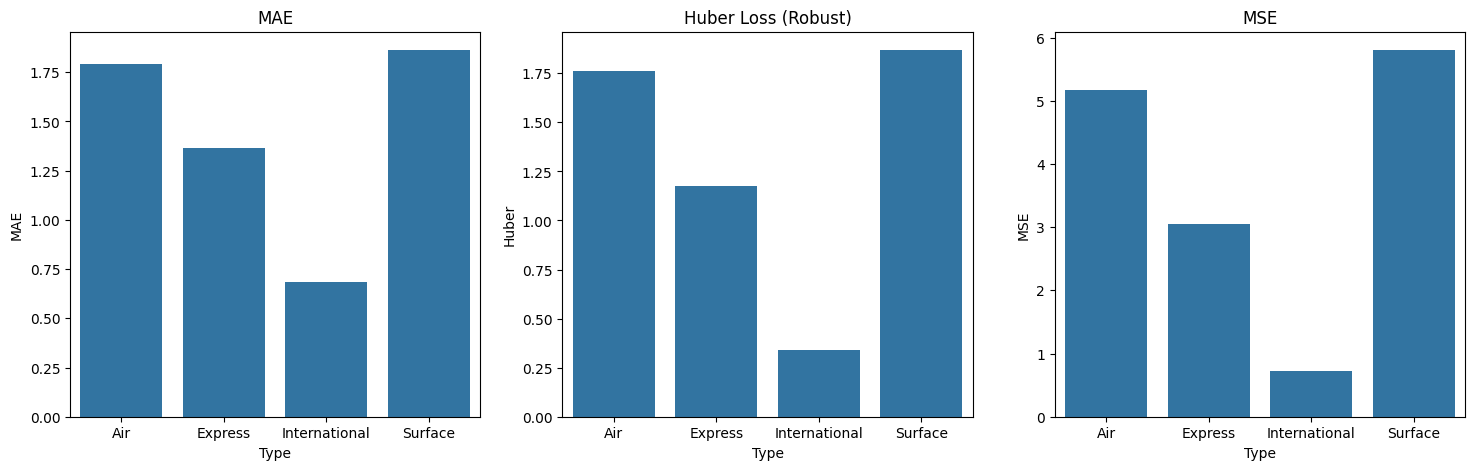

In [6]:
def custom_huber(y_true, y_pred, delta=1.5):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error**2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))

metrics = []

for target in target_columns:
    y_true = comparison_2025[f'target_{target}']
    y_pred = comparison_2025[f'Pred_{target}']
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    huber = custom_huber(y_true, y_pred)
    
    metrics.append({'Type': target, 'MAE': mae, 'MSE': mse, 'Huber': huber})

met_df = pd.DataFrame(metrics)
print("Backtest (2025) Metrics:")
print(met_df.round(2))

# Visualize Metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(data=met_df, x='Type', y='MAE', ax=axes[0]).set_title('MAE')
sns.barplot(data=met_df, x='Type', y='Huber', ax=axes[1]).set_title('Huber Loss (Robust)')
sns.barplot(data=met_df, x='Type', y='MSE', ax=axes[2]).set_title('MSE')
plt.show()

--- 
# 6. Full 2026 Forecast (Recursive) & Seasonality Overlay
We retrain on **ALL** data (2021-2025) and execute the final 365-day prediction for 2026.
Then, we compare the **2026 Forecast** against **2021-2025 History** in a single chart.

Forecasting 2026 Month 1...


/tmp/ipykernel_355732/2565815945.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.9250009059906006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  preds_to_store.loc[preds_to_store['company_name'] == comp, target] = p
/tmp/ipykernel_355732/2565815945.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.169813871383667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  preds_to_store.loc[preds_to_store['company_name'] == comp, target] = p
/tmp/ipykernel_355732/2565815945.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6024423837661743' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  preds_to_store.loc[preds_

Forecasting 2026 Month 1...


Forecasting 2026 Month 3...


Forecasting 2026 Month 4...


Forecasting 2026 Month 5...


Forecasting 2026 Month 5...


Forecasting 2026 Month 6...


Forecasting 2026 Month 7...


Forecasting 2026 Month 8...


Forecasting 2026 Month 9...


Forecasting 2026 Month 10...


Forecasting 2026 Month 11...


Forecasting 2026 Month 12...


2026 Forecast Generated.


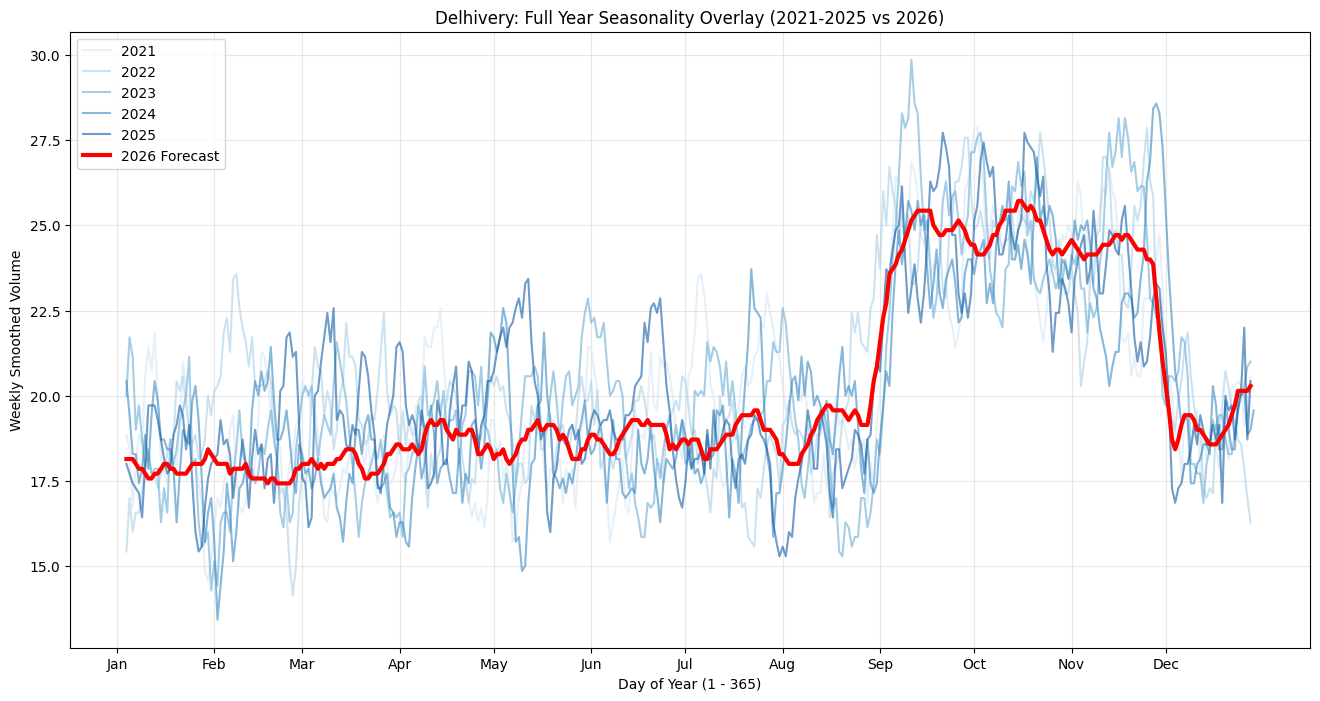

In [7]:
# Re-train Final Models
final_models = {}
for target in target_columns:
    m = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
    m.fit(df_clean[feature_cols], df_clean[f'target_{target}'])
    final_models[target] = m

# 2026 Loop
dates_2026 = pd.date_range('2026-01-01', '2026-12-31', freq='D')

# Robust History Maintenance
simulation_history = df_daily.copy()
simulation_history = simulation_history[['booking_date', 'company_name', 'company_encoded'] + target_columns]

predictions_2026 = []

for i, cur_date in enumerate(dates_2026):
    if i % 30 == 0: print(f"Forecasting 2026 Month {cur_date.month}...")

    recent = simulation_history.groupby('company_name').tail(10).copy()
    
    temp_rows = []
    for comp in companies:
        r = {'booking_date': cur_date, 'company_name': comp, 'company_encoded': le.transform([comp])[0]}
        for t in target_columns: r[t] = 0
        temp_rows.append(r)
    
    temp_df = pd.DataFrame(temp_rows)
    combined = pd.concat([recent, temp_df], ignore_index=True).sort_values(['company_name', 'booking_date'])
    
    # Recalc Features
    for col in target_columns:
         combined[f'lag_1_{col}'] = combined.groupby('company_name')[col].shift(1)
         combined[f'lag_7_{col}'] = combined.groupby('company_name')[col].shift(7)
         combined[f'roll_7_{col}'] = combined.groupby('company_name')[col].transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())

    combined['day_of_week'] = combined['booking_date'].dt.dayofweek
    combined['day'] = combined['booking_date'].dt.day
    combined['month'] = combined['booking_date'].dt.month
    
    todays_data = combined[combined['booking_date'] == cur_date].copy()
    preds_to_store = todays_data[['booking_date', 'company_name', 'company_encoded'] + target_columns].copy()
    
    row_preds = []
    for idx, row_series in todays_data.iterrows():
        # Predict per row
        comp = row_series['company_name']
        res_row = {'Date': cur_date, 'Company': comp, 'Total_Vol': 0}
        
        # We need a dataframe for predict, not a series
        row_df = pd.DataFrame([row_series]) 
        
        for target in target_columns:
            p = final_models[target].predict(row_df[feature_cols])[0]
            p = np.maximum(0, p)
            # Update store
            preds_to_store.loc[preds_to_store['company_name'] == comp, target] = p
            res_row[target] = int(round(p))
            res_row['Total_Vol'] += int(round(p))
        row_preds.append(res_row)
        
    # Append to History
    simulation_history = pd.concat([simulation_history, preds_to_store], ignore_index=True)
    predictions_2026.extend(row_preds)

forecast_df = pd.DataFrame(predictions_2026)
print("2026 Forecast Generated.")

# =========================================
#  THE SPAGHETTI PLOT (2026 vs 2021-25)
# =========================================
company_to_plot = 'Delhivery'

plt.figure(figsize=(16, 8))

# 1. Plot Historical Years (Faint)
hist_years = sorted(df_clean['booking_date'].dt.year.unique())
colors = sns.color_palette("Blues", n_colors=len(hist_years))

for i, year in enumerate(hist_years):
    # Get data for this company & year
    y_data = df_daily[(df_daily['company_name'] == company_to_plot) & 
                      (df_daily['booking_date'].dt.year == year)].copy()
    
    # Calculate Total Volume (Sum of types)
    y_data['ToT'] = y_data[target_columns].sum(axis=1)
    
    # Use DayOfYear for X-Axis
    y_data = y_data.set_index('booking_date')
    x_doy = y_data.index.dayofyear
    
    # Smooth it slightly (Weekly Rolling) for readability
    y_smooth = y_data['ToT'].rolling(7, center=True).mean()
    
    plt.plot(x_doy, y_smooth, label=f"{year}", color=colors[i], alpha=0.6, linewidth=1.5)

# 2. Plot 2026 Forecast (Bold Red)
forecast_plot = forecast_df[forecast_df['Company'] == company_to_plot].copy()
forecast_plot['booking_date'] = pd.to_datetime(forecast_plot['Date'])
forecast_plot = forecast_plot.set_index('booking_date')

x_pred_doy = forecast_plot.index.dayofyear
y_pred_smooth = forecast_plot['Total_Vol'].rolling(7, center=True).mean()

plt.plot(x_pred_doy, y_pred_smooth, label="2026 Forecast", color='red', linewidth=3.0)

plt.title(f"{company_to_plot}: Full Year Seasonality Overlay (2021-2025 vs 2026)")
plt.xlabel("Day of Year (1 - 365)")
plt.ylabel("Weekly Smoothed Volume")

# X-Axis Month Markers
from calendar import month_abbr
month_starts = [pd.Timestamp(f'2026-{m}-01').dayofyear for m in range(1, 13)]
plt.xticks(month_starts, list(month_abbr)[1:])

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

--- 
# 7. The "Oracle" Prediction Function

In [8]:
def predict_next_shipment(company_name, model_type='xgboost'):
    # Inference Source: df_daily (Contains Dec 31)
    last_row = df_daily[df_daily['company_name'] == company_name].sort_values('booking_date').iloc[-1]
    
    # Verify Next Date is Jan 1
    next_date = last_row['booking_date'] + pd.Timedelta(days=1)
    
    input_data = last_row[feature_cols].copy()
    input_data['day_of_week'] = next_date.dayofweek
    input_data['day'] = next_date.day
    input_data['month'] = next_date.month
    
    models = xgb_models if model_type == 'xgboost' else rf_models
    
    preds = {}
    total = 0
    for t in target_columns:
        # Use model to predict
        val = int(max(0, round(models[t].predict(pd.DataFrame([input_data]))[0])))
        preds[t] = val
        total += val
        
    prob = {t: (v/total if total > 0 else 0) for t,v in preds.items()}
    top_type = max(prob, key=prob.get)
    
    print(f"\n>>> {company_name.upper()} Prediction ({model_type.upper()}) <<<")
    print(f"Date: {next_date.date()}")
    print(f"Volume: {total}")
    print(f"Most Likely: {top_type} ({prob[top_type]:.1%})")
    
    return {'date': next_date, 'vol': total, 'dist': prob}

# Demo
_ = predict_next_shipment('Delhivery', 'xgboost')


>>> DELHIVERY Prediction (XGBOOST) <<<
Date: 2026-01-01
Volume: 17
Most Likely: Surface (41.2%)
